In [163]:
import pyfesom2 as pf
import xarray as xr
import os
import pandas as pd
from collections import OrderedDict
from itertools import product
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

In [164]:
# parameters cell
meshpath = "/Users/nkolduno/PYTHON/DATA/core2_meanz_mesh/"
abg = [50, 15, -90]
variable = 'temp'
input_paths = [
    
    "/Users/nkolduno/PYTHON/DATA/output_7_10",
]
input_names = ['opt1']
years = range(1978, 1986)
reference_path = "/Users/nkolduno/PYTHON/DATA/output_7_8/"
reference_name = 'control'
reference_years = years
rowscol=[1,1]
bbox = [-180, 180, -80, 90]
res = [360, 180]
mapproj='pc'
figsize=(24, 14)
depth = 0
levels = [-0.1, 0.1, 41]
units = r'$^\circ$C'
dpi=200
how="mean"
ofile = None
cached_path = None

In [165]:
if input_names is None:
    input_names = []
    for run in input_paths:
        run = os.path.join(run, '')
        input_names.append(run.split('/')[-2])

In [166]:
mesh = pf.load_mesh(meshpath, abg=abg, 
                    usepickle=True, usejoblib=False)

/Users/nkolduno/PYTHON/DATA/core2_meanz_mesh/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /Users/nkolduno/PYTHON/DATA/core2_meanz_mesh/pickle_mesh_py3_fesom2


In [167]:
def get_data_cache(cached_path,
                   exp_name,
                   exp_path,
                   variable,
                   years,
                   mesh,
                   depth=None, 
                   how='mean',
                   compute=True,
                   silent=True):
    
    if cached_path is None:
        cached_path = exp_path
    
    if depth is None:
        depth_cache = '3d'
    else:
        depth_cache = depth
        
    if how is None:
        how_cache = "timeseries"
    else:
        how_cache = "how"
        
    if cached_path is False:
        data_out = pf.get_data(exp_path,
                               variable,
                               years,
                               mesh,
                               depth = depth,
                               how=how,
                               compute=compute,
                               silent=silent)
        return data_out
    
    else:
        if not isinstance(years, (list, np.ndarray, range)):
            years_str = [years]
        else:
            years_str = years
        print(years_str)
        cached_file = f"{cached_path}/{exp_name}_{variable}_{years_str[0]}_{years_str[-1]}_{depth_cache}_{how_cache}.nc"
        print(cached_file)
        if os.path.exists(cached_file):
            print('use cached')
            data_out = xr.open_dataset(cached_file)
            data_out = data_out[variable]
        else:
            print('compute')
            data_out = pf.get_data(exp_path,
                               variable,
                               years,
                               mesh,
                               depth = depth,
                               how=how,
                               compute=False,
                               silent=silent)
            data_out.to_netcdf(cached_file)
    if compute:
        data_out = data_out.compute()
        data_out = data_out.data
                
    return data_out

In [168]:
plotds = OrderedDict()
# data_reference = pf.get_data(reference_path, variable, reference_years, mesh, depth = depth, how=how, compute=True, silent=True)
data_reference = get_data_cache(cached_path, reference_name, reference_path, variable, reference_years, mesh, depth = depth, how=how, compute=True, silent=True)
plotds[depth] = {}
for exp_path, exp_name  in zip(input_paths, input_names):
    data_test      = get_data_cache(cached_path, exp_name, exp_path, variable, years, mesh, depth = depth, how=how, compute=True, silent=True)
    data_difference= data_test - data_reference
    title = exp_name+" - "+reference_name
    plotds[depth][title] = {}
    plotds[depth][title]['data'] = data_difference
    if (data_difference.max() == data_difference.min() == 0):
        plotds[depth][title]['nodiff'] = True
    else:
        plotds[depth][title]['nodiff'] = False

range(1978, 1986)
/Users/nkolduno/PYTHON/DATA/output_7_8//control_temp_1978_1985_0_mean.nc
use cached
range(1978, 1986)
/Users/nkolduno/PYTHON/DATA/output_7_10/opt1_temp_1978_1985_0_mean.nc
use cached


In [169]:
def data_to_plot(plotds, depth):
    plot_data = []
    plot_names = []
    for key, value in plotds[depth].items():
        if value['nodiff'] is False:
            plot_data.append(value['data'])
            plot_names.append(key)
                
    return plot_data, plot_names

In [170]:
plot_data, plot_names = data_to_plot(plotds, depth)
if not plot_data:
    print('There is no difference between fields')
    identical = True
else:
    identical = False

if len(plot_data) == 1:
    plot_data = plot_data[0]
    plot_names = plot_names[0]


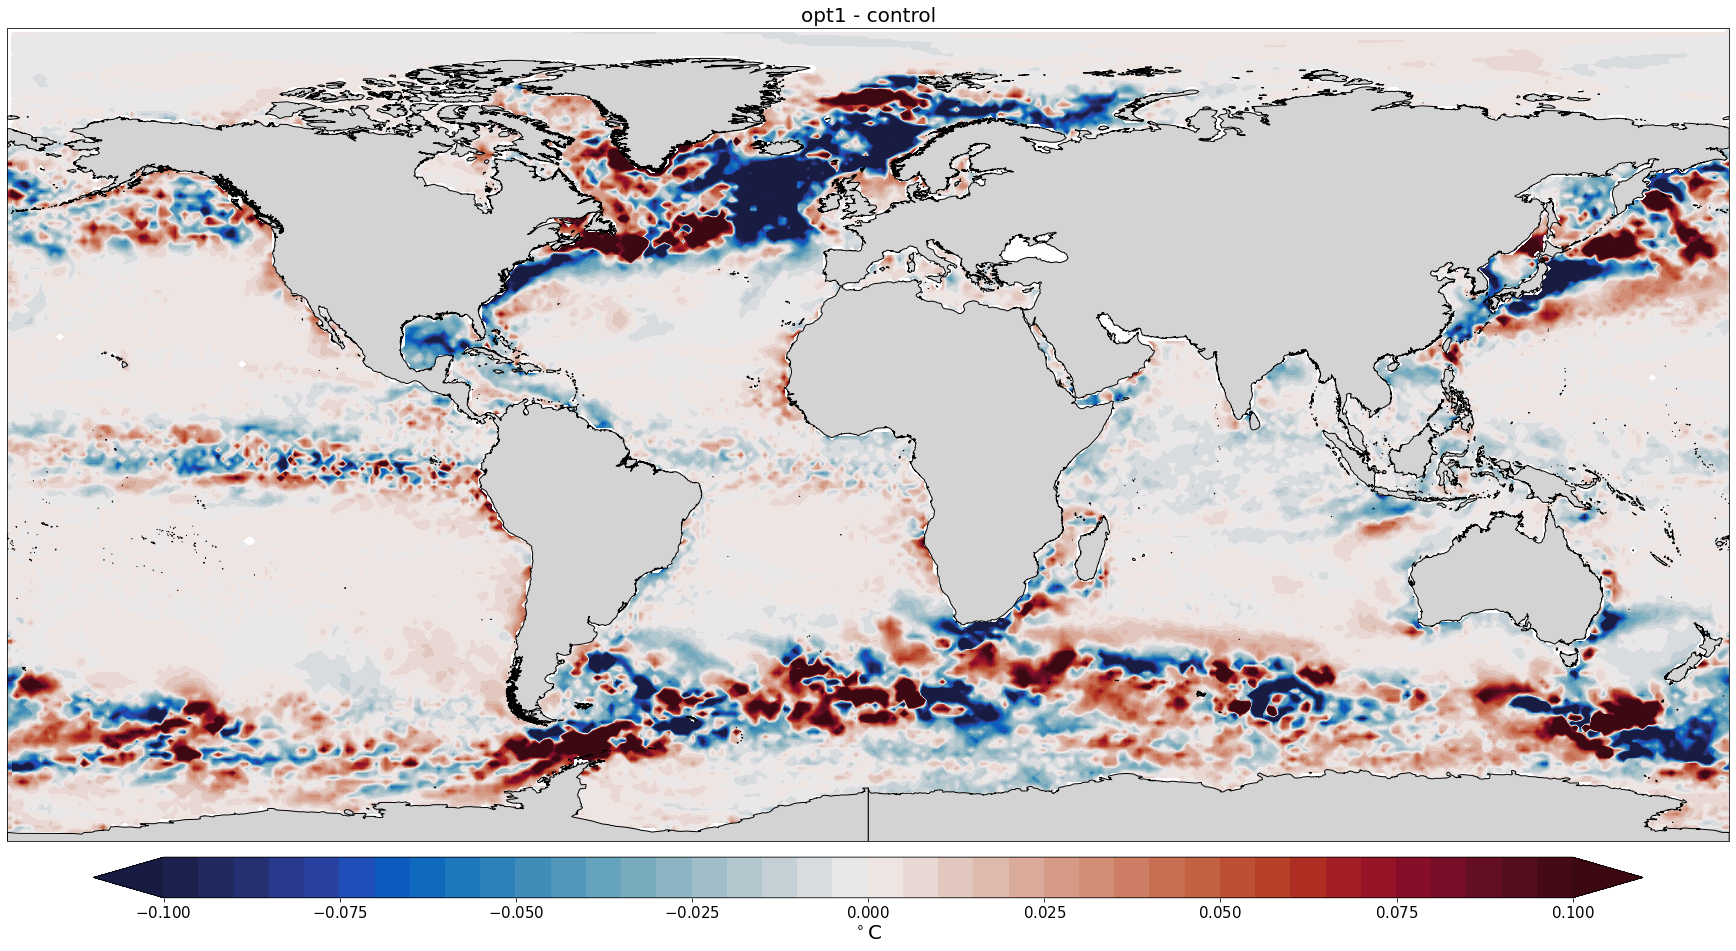

In [171]:
if not identical:
    pf.plot(mesh, 
        plot_data,
        rowscol=rowscol,
        titles=plot_names,
        mapproj=mapproj,
        cmap='balance', 
        levels=levels,
        figsize = figsize, 
        box=bbox, 
        res = res,
        units = units);
if ofile is not None:
    plt.savefig(ofile, dpi=dpi)
    os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    os.system(f'mv {ofile}_trimmed.png {ofile}')